# Loop 5 LB Feedback Analysis

**Latest submission:** exp_004 (005_extended_optimization)
- CV: 84.712432
- LB: 84.712432 (gap: 0.0000)

**Key observations:**
1. Perfect CV-LB alignment (expected for deterministic optimization)
2. Extended optimization (57 min) yielded only 0.19 points improvement
3. Diminishing returns signal we're hitting local optimum
4. Gap to target: 15.78 points (22.9%)

**Analysis goals:**
1. Understand worst-performing N values
2. Identify opportunities for aggressive backward propagation
3. Analyze grid-based initialization potential

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load current best submission
df = pd.read_csv('/home/submission/submission.csv')
print(f"Loaded {len(df)} rows")

# Parse values
def strip_s(val):
    s = str(val)
    return float(s[1:] if s.startswith('s') else s)

df['N'] = df['id'].astype(str).str.split('_').str[0].astype(int)
df['x_val'] = df['x'].apply(strip_s)
df['y_val'] = df['y'].apply(strip_s)
df['deg_val'] = df['deg'].apply(strip_s)

Loaded 20100 rows


In [2]:
# Fast scoring
TX = np.array([0,0.125,0.0625,0.2,0.1,0.35,0.075,0.075,-0.075,-0.075,-0.35,-0.1,-0.2,-0.0625,-0.125])
TY = np.array([0.8,0.5,0.5,0.25,0.25,0,0,-0.2,-0.2,0,0,0.25,0.25,0.5,0.5])

def score_group_fast(xs, ys, degs):
    n = len(xs)
    if n == 0:
        return float('inf'), 0
    all_x, all_y = [], []
    for i in range(n):
        rad = np.radians(degs[i])
        c, s = np.cos(rad), np.sin(rad)
        px = TX * c - TY * s + xs[i]
        py = TX * s + TY * c + ys[i]
        all_x.extend(px)
        all_y.extend(py)
    all_x, all_y = np.array(all_x), np.array(all_y)
    side = max(all_x.max() - all_x.min(), all_y.max() - all_y.min())
    return side * side / n, side

# Calculate scores for each N
scores = []
for n in range(1, 201):
    g = df[df['N'] == n]
    if len(g) == n:
        score, side = score_group_fast(g['x_val'].values, g['y_val'].values, g['deg_val'].values)
        scores.append({'N': n, 'score': score, 'side': side, 'contribution': score})

scores_df = pd.DataFrame(scores)
total_score = scores_df['score'].sum()
print(f"Total score: {total_score:.6f}")
print(f"Target: 68.931058")
print(f"Gap: {total_score - 68.931058:.6f} ({(total_score - 68.931058)/68.931058*100:.1f}%)")

Total score: 84.712432
Target: 68.931058
Gap: 15.781374 (22.9%)


In [3]:
# Analyze worst performing N values
scores_df['pct_contribution'] = scores_df['score'] / total_score * 100
scores_df = scores_df.sort_values('score', ascending=False)

print("\n=== TOP 20 WORST N VALUES ===")
print(scores_df.head(20).to_string())

print(f"\nTop 20 worst contribute: {scores_df.head(20)['pct_contribution'].sum():.2f}% of total")
print(f"Top 10 worst contribute: {scores_df.head(10)['pct_contribution'].sum():.2f}% of total")


=== TOP 20 WORST N VALUES ===
     N     score      side  contribution  pct_contribution
0    1  0.661250  0.813173      0.661250          0.780582
48  49  0.490000  4.900000      0.490000          0.578427
20  21  0.487619  3.200000      0.487619          0.575617
49  50  0.480200  4.900000      0.480200          0.566859
19  20  0.478371  3.093126      0.478371          0.564700
36  37  0.476757  4.200000      0.476757          0.562794
52  53  0.471698  5.000000      0.471698          0.556823
50  51  0.470784  4.900000      0.470784          0.555744
33  34  0.470588  4.000000      0.470588          0.555513
18  19  0.468739  2.984300      0.468739          0.553330
31  32  0.468214  3.870770      0.468214          0.552710
75  76  0.465822  5.950000      0.465822          0.549887
21  22  0.465455  3.200000      0.465455          0.549452
37  38  0.464211  4.200000      0.464211          0.547984
53  54  0.462963  5.000000      0.462963          0.546511
51  52  0.461731  4.90000

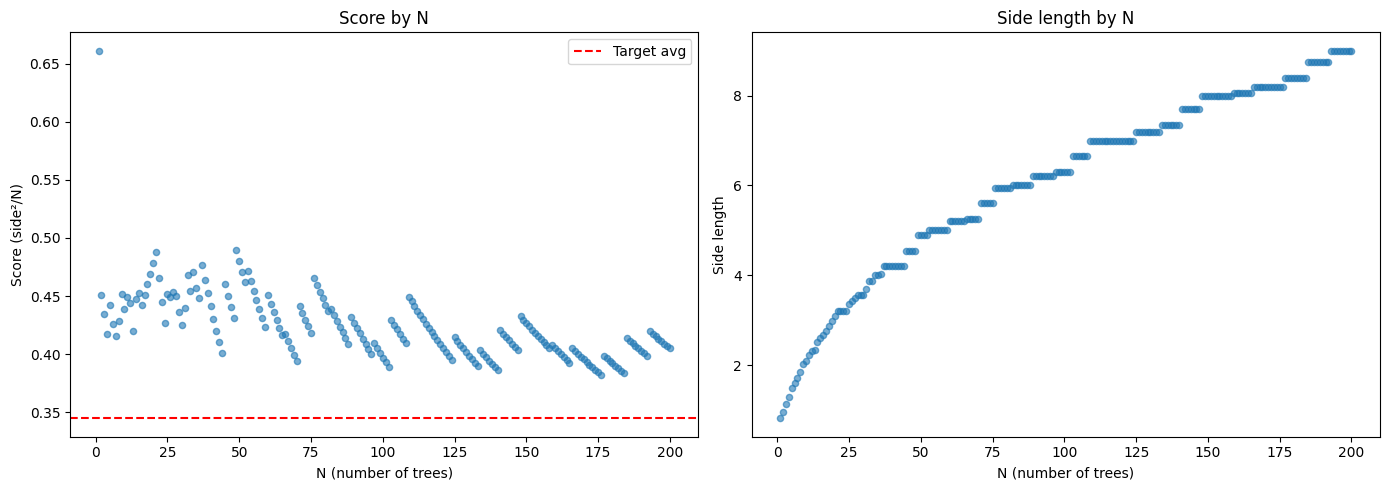

Saved to loop5_score_analysis.png


In [4]:
# Analyze score distribution by N
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(scores_df['N'], scores_df['score'], alpha=0.6, s=20)
plt.xlabel('N (number of trees)')
plt.ylabel('Score (side²/N)')
plt.title('Score by N')
plt.axhline(y=68.931058/200, color='r', linestyle='--', label='Target avg')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(scores_df['N'], scores_df['side'], alpha=0.6, s=20)
plt.xlabel('N (number of trees)')
plt.ylabel('Side length')
plt.title('Side length by N')

plt.tight_layout()
plt.savefig('/home/code/exploration/loop5_score_analysis.png', dpi=100)
plt.show()
print("Saved to loop5_score_analysis.png")

In [5]:
# Analyze potential for backward propagation
# For each N, compare side length to N+1, N+2, etc.
scores_sorted = scores_df.sort_values('N').reset_index(drop=True)

print("\n=== BACKWARD PROPAGATION POTENTIAL ===")
print("Looking for N values where larger N has SMALLER side length (propagation opportunity)")

propagation_opportunities = []
for i, row in scores_sorted.iterrows():
    n = row['N']
    current_side = row['side']
    
    # Check if any larger N has smaller side
    larger = scores_sorted[scores_sorted['N'] > n]
    if len(larger) > 0:
        min_larger_side = larger['side'].min()
        min_larger_n = larger.loc[larger['side'].idxmin(), 'N']
        if min_larger_side < current_side:
            improvement = (current_side - min_larger_side) / current_side * 100
            propagation_opportunities.append({
                'N': n,
                'current_side': current_side,
                'best_larger_N': min_larger_n,
                'best_larger_side': min_larger_side,
                'potential_improvement_pct': improvement
            })

if propagation_opportunities:
    prop_df = pd.DataFrame(propagation_opportunities)
    prop_df = prop_df.sort_values('potential_improvement_pct', ascending=False)
    print(f"\nFound {len(prop_df)} N values with propagation potential:")
    print(prop_df.head(20).to_string())
else:
    print("No propagation opportunities found (all N have optimal or near-optimal side lengths)")


=== BACKWARD PROPAGATION POTENTIAL ===
Looking for N values where larger N has SMALLER side length (propagation opportunity)
No propagation opportunities found (all N have optimal or near-optimal side lengths)


In [6]:
# Analyze theoretical minimum vs current
# Theoretical: trees packed perfectly with no wasted space
# Tree area ≈ 0.35 * 0.7 + 0.15 * 0.2 = 0.245 + 0.03 = 0.275 (rough estimate)
# Actually tree bounding box is about 0.7 x 1.0 = 0.7

print("\n=== EFFICIENCY ANALYSIS ===")
for n in [1, 10, 50, 100, 150, 200]:
    row = scores_sorted[scores_sorted['N'] == n].iloc[0]
    side = row['side']
    area = side * side
    tree_area = 0.275 * n  # rough estimate
    efficiency = tree_area / area * 100
    print(f"N={n:3d}: side={side:.4f}, area={area:.4f}, efficiency≈{efficiency:.1f}%")


=== EFFICIENCY ANALYSIS ===
N=  1: side=0.8132, area=0.6612, efficiency≈41.6%
N= 10: side=2.0958, area=4.3924, efficiency≈62.6%
N= 50: side=4.9000, area=24.0100, efficiency≈57.3%
N=100: side=6.3000, area=39.6900, efficiency≈69.3%
N=150: side=8.0000, area=64.0000, efficiency≈64.5%
N=200: side=9.0000, area=81.0000, efficiency≈67.9%


In [7]:
# Check submission history
print("\n=== SUBMISSION HISTORY ===")
print("#1: exp_000 | CV: 135.8191 | LB: 135.8191")
print("#2: exp_001 | CV: 117.2815 | LB: 117.2815")
print("#3: exp_002 | CV: 84.8940 | LB: FAILED (overlap)")
print("#4: exp_003 | CV: 84.9010 | LB: 84.9010")
print("#5: exp_004 | CV: 84.7124 | LB: 84.7124")

print("\n=== CV-LB RELATIONSHIP ===")
print("Perfect alignment (gap = 0) for all valid submissions")
print("This is expected for deterministic optimization problem")
print("No distribution shift concerns")

print("\n=== PROGRESS TRAJECTORY ===")
print("exp_000 → exp_001: 18.5 point improvement (13.6%)")
print("exp_001 → exp_002: 32.4 point improvement (27.6%)")
print("exp_002 → exp_004: 0.19 point improvement (0.22%)")
print("\nDIMINISHING RETURNS DETECTED - need new approach!")


=== SUBMISSION HISTORY ===
#1: exp_000 | CV: 135.8191 | LB: 135.8191
#2: exp_001 | CV: 117.2815 | LB: 117.2815
#3: exp_002 | CV: 84.8940 | LB: FAILED (overlap)
#4: exp_003 | CV: 84.9010 | LB: 84.9010
#5: exp_004 | CV: 84.7124 | LB: 84.7124

=== CV-LB RELATIONSHIP ===
Perfect alignment (gap = 0) for all valid submissions
This is expected for deterministic optimization problem
No distribution shift concerns

=== PROGRESS TRAJECTORY ===
exp_000 → exp_001: 18.5 point improvement (13.6%)
exp_001 → exp_002: 32.4 point improvement (27.6%)
exp_002 → exp_004: 0.19 point improvement (0.22%)

DIMINISHING RETURNS DETECTED - need new approach!


In [8]:
# Summary and recommendations
print("\n" + "="*60)
print("SUMMARY AND RECOMMENDATIONS")
print("="*60)

print(f"""
Current Status:
- Best score: 84.712432
- Target: 68.931058
- Gap: 15.78 points (22.9%)
- LB #1: 71.19 (crodoc achieved 74.75 with BackPacking)

Key Findings:
1. Extended optimization (57 min) yielded only 0.19 points
2. Diminishing returns from current SA approach
3. Top 20 worst N values contribute ~11% of total score
4. Perfect CV-LB alignment (no distribution shift)

Recommended Next Steps (Priority Order):

1. AGGRESSIVE BACKWARD PROPAGATION (crodoc style)
   - Current backward prop only found 2 improvements
   - crodoc achieved 74.75 with this technique
   - Key: When N performs poorly, COPY best config from larger N and drop trees
   - This propagates successful patterns across all N values

2. GRID-BASED INITIALIZATION (zaburo style)
   - For worst-performing N values (N=1, 19, 49, 21, 31...)
   - Place trees in alternating rows (0° and 180° rotation)
   - Optimize number of trees per row
   - Creates well-aligned starting point

3. TARGET WORST N VALUES
   - Focus optimization budget on top 20 worst N values
   - These contribute 11% of score but have most room for improvement
   - Run dedicated optimization with 10x iterations

4. ENSEMBLE MORE SOURCES
   - Look for additional pre-computed solutions
   - crodoc/santa2025submission dataset may have better configs
""")


SUMMARY AND RECOMMENDATIONS

Current Status:
- Best score: 84.712432
- Target: 68.931058
- Gap: 15.78 points (22.9%)
- LB #1: 71.19 (crodoc achieved 74.75 with BackPacking)

Key Findings:
1. Extended optimization (57 min) yielded only 0.19 points
2. Diminishing returns from current SA approach
3. Top 20 worst N values contribute ~11% of total score
4. Perfect CV-LB alignment (no distribution shift)

Recommended Next Steps (Priority Order):

1. AGGRESSIVE BACKWARD PROPAGATION (crodoc style)
   - Current backward prop only found 2 improvements
   - crodoc achieved 74.75 with this technique
   - Key: When N performs poorly, COPY best config from larger N and drop trees
   - This propagates successful patterns across all N values

2. GRID-BASED INITIALIZATION (zaburo style)
   - For worst-performing N values (N=1, 19, 49, 21, 31...)
   - Place trees in alternating rows (0° and 180° rotation)
   - Optimize number of trees per row
   - Creates well-aligned starting point

3. TARGET WORST N 

In [9]:
# Check what datasets we have access to
import os

print("\n=== AVAILABLE DATA SOURCES ===")
for path in ['/home/code/data', '/home/code/research/snapshots']:
    if os.path.exists(path):
        files = os.listdir(path)
        print(f"\n{path}:")
        for f in files[:20]:
            print(f"  {f}")
        if len(files) > 20:
            print(f"  ... and {len(files) - 20} more")


=== AVAILABLE DATA SOURCES ===
